<a href="https://colab.research.google.com/github/cdiegor/Simulacao/blob/main/Pr%C3%A1tica_3_Teoria_das_Filas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teoria e prática das Filas


## Filas M/M/· — Experimentos de Simulação em Python

Este notebook mostra **experimentos computacionais** com as filas:

- M/M/1  
- M/M/1/K (capacidade finita)  
- M/M/∞ (infinitos servidores)  
- M/M/c (c servidores)  
- M/M/1 com **prioridades** (2 classes, não-preemptiva)

Objetivos:

- comparar as métricas teóricas \\(L,L_q,W,W_q\\) com resultados de simulação;
- visualizar a **convergência** das médias amostrais para o regime estacionário.

## Importando as bibliotecas

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

def make_rng(seed=None):
    # Gerador NumPy com PCG64 (boa qualidade, rápido)
    return np.random.Generator(np.random.PCG64(seed))


## Métricas teóricas de cada uma das filas neste caderno

In [6]:
def mm1_metrics(lam, mu):
    """M/M/1 com λ, μ e ρ = λ/μ < 1."""
    rho = lam / mu
    if rho >= 1:
        raise ValueError("M/M/1 instável: rho >= 1")
    L  = rho / (1 - rho)
    Lq = rho**2 / (1 - rho)
    W  = 1 / (mu - lam)
    Wq = lam / (mu * (mu - lam))
    return {"rho": rho, "L": L, "Lq": Lq, "W": W, "Wq": Wq}

def mm1K_metrics(lam, mu, K):
    """M/M/1/K com capacidade total K (inclui servidor)."""
    rho = lam / mu
    if abs(rho - 1) < 1e-12:
        raise ValueError("Caso ρ≈1 não tratado; use ρ≠1.")
    # Probabilidades estacionárias (geométrica truncada)
    norm = (1 - rho) / (1 - rho**(K+1))
    P = np.array([norm * rho**n for n in range(K+1)])  # P_n
    L = np.sum(np.arange(K+1) * P)
    P_block = P[-1]
    lam_eff = lam * (1 - P_block)        # taxa efetiva de clientes aceitos
    W  = L / lam_eff if lam_eff > 0 else math.inf
    Lq = np.sum(np.maximum(np.arange(K+1) - 1, 0) * P)
    Wq = Lq / lam_eff if lam_eff > 0 else math.inf
    return {
        "rho": rho, "L": L, "Lq": Lq, "W": W, "Wq": Wq,
        "P_block": P_block, "lam_eff": lam_eff
    }

def mminf_metrics(lam, mu):
    """M/M/∞: infinitos servidores, sem fila."""
    L = lam / mu
    W = 1 / mu
    return {"rho": 0.0, "L": L, "Lq": 0.0, "W": W, "Wq": 0.0}

def mmc_metrics(lam, mu, c):
    """M/M/c com Erlang C."""
    a = lam / mu
    rho = lam / (c * mu)
    if rho >= 1:
        raise ValueError("M/M/c instável: rho >= 1")
    # P0 (normalização)
    s = sum(a**k / math.factorial(k) for k in range(c))
    s += (a**c / math.factorial(c)) * (c * mu) / (c * mu - lam)
    P0 = 1 / s
    # Prob. de espera (Erlang C)
    P_wait = (a**c / math.factorial(c)) * (c * mu) / (c * mu - lam) * P0
    Lq = P_wait * (rho / (1 - rho))
    Wq = Lq / lam
    W  = Wq + 1 / mu
    L  = lam * W
    return {
        "rho": rho, "L": L, "Lq": Lq, "W": W, "Wq": Wq,
        "P_wait": P_wait, "P0": P0
    }

def mm1_priority_overall_metrics(lam1, lam2, mu):
    """
    Agregado (ignorando classes), M/M/1 com λ_total = λ1 + λ2.
    Métricas por classe são mais complicadas e não estão aqui.
    """
    return mm1_metrics(lam1 + lam2, mu)


## Simulação de filas M/M/1 e M/M/1/K

In [7]:
def simulate_mm1(lam, mu, T_max, seed=None):
    """
    Simula um M/M/1 até tempo T_max.
    Retorna médias de L, Lq (via integrais) e W, Wq (via amostras).
    """
    rng = make_rng(seed)
    t = 0.0
    n = 0                    # nº no sistema
    queue = []               # tempos de chegada em espera
    busy = False
    current_arrival = None
    current_service_time = None

    next_arr = rng.exponential(1/lam)
    next_dep = math.inf

    area_L = 0.0
    area_Lq = 0.0

    times = []
    avg_L = []
    avg_Lq = []

    W_samples = []
    Wq_samples = []

    while t < T_max:
        # escolhe próximo evento
        if next_arr < next_dep:
            t_event = next_arr
            event = "arrival"
        else:
            t_event = next_dep
            event = "departure"

        if t_event > T_max:
            dt = T_max - t
            area_L += n * dt
            area_Lq += max(n - 1, 0) * dt
            t = T_max
            break

        dt = t_event - t
        area_L += n * dt
        area_Lq += max(n - 1, 0) * dt
        t = t_event

        if t > 0:
            times.append(t)
            avg_L.append(area_L / t)
            avg_Lq.append(area_Lq / t)

        if event == "arrival":
            n += 1
            if not busy:
                # entra direto em serviço
                busy = True
                current_arrival = t
                current_service_time = rng.exponential(1/mu)
                next_dep = t + current_service_time
            else:
                queue.append(t)
            next_arr = t + rng.exponential(1/lam)
        else:
            # saída
            n -= 1
            W  = t - current_arrival
            Wq = W - current_service_time
            W_samples.append(W)
            Wq_samples.append(Wq)
            if queue:
                current_arrival = queue.pop(0)
                current_service_time = rng.exponential(1/mu)
                next_dep = t + current_service_time
                busy = True
            else:
                busy = False
                next_dep = math.inf

    L_hat  = area_L / t
    Lq_hat = area_Lq / t
    W_hat  = float(np.mean(W_samples)) if W_samples else math.nan
    Wq_hat = float(np.mean(Wq_samples)) if Wq_samples else math.nan

    return {
        "times": np.array(times),
        "avg_L": np.array(avg_L),
        "avg_Lq": np.array(avg_Lq),
        "L": L_hat, "Lq": Lq_hat,
        "W": W_hat, "Wq": Wq_hat,
        "W_samples": np.array(W_samples),
        "Wq_samples": np.array(Wq_samples),
    }


def simulate_mm1K(lam, mu, K, T_max, seed=None):
    """
    M/M/1/K: clientes que chegam com n >= K são bloqueados.
    """
    rng = make_rng(seed)
    t = 0.0
    n = 0
    queue = []
    busy = False
    current_arrival = None
    current_service_time = None

    next_arr = rng.exponential(1/lam)
    next_dep = math.inf

    area_L = 0.0
    area_Lq = 0.0
    blocked = 0
    arrived = 0

    times = []
    avg_L = []
    avg_Lq = []

    W_samples = []
    Wq_samples = []

    while t < T_max:
        if next_arr < next_dep:
            t_event = next_arr
            event = "arrival"
        else:
            t_event = next_dep
            event = "departure"

        if t_event > T_max:
            dt = T_max - t
            area_L += n * dt
            area_Lq += max(n - 1, 0) * dt
            t = T_max
            break

        dt = t_event - t
        area_L += n * dt
        area_Lq += max(n - 1, 0) * dt
        t = t_event

        if t > 0:
            times.append(t)
            avg_L.append(area_L / t)
            avg_Lq.append(area_Lq / t)

        if event == "arrival":
            arrived += 1
            if n >= K:
                blocked += 1
            else:
                n += 1
                if not busy:
                    busy = True
                    current_arrival = t
                    current_service_time = rng.exponential(1/mu)
                    next_dep = t + current_service_time
                else:
                    queue.append(t)
            next_arr = t + rng.exponential(1/lam)
        else:
            n -= 1
            W  = t - current_arrival
            Wq = W - current_service_time
            W_samples.append(W)
            Wq_samples.append(Wq)
            if queue:
                current_arrival = queue.pop(0)
                current_service_time = rng.exponential(1/mu)
                next_dep = t + current_service_time
                busy = True
            else:
                busy = False
                next_dep = math.inf

    L_hat  = area_L / t
    Lq_hat = area_Lq / t
    W_hat  = float(np.mean(W_samples)) if W_samples else math.nan
    Wq_hat = float(np.mean(Wq_samples)) if Wq_samples else math.nan
    P_block_hat = blocked / arrived if arrived > 0 else 0.0
    lam_eff_hat = lam * (1 - P_block_hat)

    return {
        "times": np.array(times),
        "avg_L": np.array(avg_L),
        "avg_Lq": np.array(avg_Lq),
        "L": L_hat, "Lq": Lq_hat,
        "W": W_hat, "Wq": Wq_hat,
        "P_block": P_block_hat, "lam_eff": lam_eff_hat,
    }


## Simulação de filas M/M/∞ e M/M/c

In [8]:
import heapq

def simulate_mminf(lam, mu, T_max, seed=None):
    """
    M/M/∞: cada cliente recebe servidor próprio, sem fila.
    W = tempo de serviço ~ Exp(μ).
    """
    rng = make_rng(seed)
    t = 0.0
    n = 0
    dep_heap = []   # min-heap de tempos de partida

    next_arr = rng.exponential(1/lam)

    area_L = 0.0
    times = []
    avg_L = []
    W_samples = []

    while t < T_max:
        next_dep = dep_heap[0] if dep_heap else math.inf
        if next_arr < next_dep:
            t_event = next_arr
            event = "arrival"
        else:
            t_event = next_dep
            event = "departure"

        if t_event > T_max:
            dt = T_max - t
            area_L += n * dt
            t = T_max
            break

        dt = t_event - t
        area_L += n * dt
        t = t_event

        if t > 0:
            times.append(t)
            avg_L.append(area_L / t)

        if event == "arrival":
            n += 1
            service_time = rng.exponential(1/mu)
            dep_time = t + service_time
            heapq.heappush(dep_heap, dep_time)
            W_samples.append(service_time)
            next_arr = t + rng.exponential(1/lam)
        else:
            n -= 1
            heapq.heappop(dep_heap)

    L_hat = area_L / t
    W_hat = float(np.mean(W_samples)) if W_samples else math.nan

    return {
        "times": np.array(times),
        "avg_L": np.array(avg_L),
        "L": L_hat, "Lq": 0.0,
        "W": W_hat, "Wq": 0.0,
    }


def simulate_mmc(lam, mu, c, T_max, seed=None):
    """
    M/M/c com disciplina FIFO.
    """
    rng = make_rng(seed)
    t = 0.0
    n = 0
    busy = 0
    queue = []
    dep_heap = []  # (dep_time, service_time, arrival_time)

    next_arr = rng.exponential(1/lam)

    area_L = 0.0
    area_Lq = 0.0

    times = []
    avg_L = []
    avg_Lq = []

    W_samples = []
    Wq_samples = []

    while t < T_max:
        next_dep = dep_heap[0][0] if dep_heap else math.inf
        if next_arr < next_dep:
            t_event = next_arr
            event = "arrival"
        else:
            t_event = next_dep
            event = "departure"

        if t_event > T_max:
            dt = T_max - t
            area_L += n * dt
            area_Lq += max(n - busy, 0) * dt
            t = T_max
            break

        dt = t_event - t
        area_L += n * dt
        area_Lq += max(n - busy, 0) * dt
        t = t_event

        if t > 0:
            times.append(t)
            avg_L.append(area_L / t)
            avg_Lq.append(area_Lq / t)

        if event == "arrival":
            n += 1
            if busy < c:
                # entra direto em serviço
                busy += 1
                arrival_time = t
                service_time = rng.exponential(1/mu)
                dep_time = t + service_time
                heapq.heappush(dep_heap, (dep_time, service_time, arrival_time))
            else:
                queue.append(t)
            next_arr = t + rng.exponential(1/lam)
        else:
            dep_time, service_time, arrival_time = heapq.heappop(dep_heap)
            n -= 1
            busy -= 1
            W  = t - arrival_time
            Wq = W - service_time
            W_samples.append(W)
            Wq_samples.append(Wq)
            if queue:
                busy += 1
                arrival_time = queue.pop(0)
                service_time = rng.exponential(1/mu)
                dep_time = t + service_time
                heapq.heappush(dep_heap, (dep_time, service_time, arrival_time))

    L_hat  = area_L / t
    Lq_hat = area_Lq / t
    W_hat  = float(np.mean(W_samples)) if W_samples else math.nan
    Wq_hat = float(np.mean(Wq_samples)) if Wq_samples else math.nan

    return {
        "times": np.array(times),
        "avg_L": np.array(avg_L),
        "avg_Lq": np.array(avg_Lq),
        "L": L_hat, "Lq": Lq_hat,
        "W": W_hat, "Wq": Wq_hat,
    }


## Bônus: simulação de filas com prioridade M/M/1/∞/prioridades

In [9]:
def simulate_mm1_priority(lam1, lam2, mu, T_max, seed=None):
    """
    M/M/1 com duas classes, prioridade NÃO-preemptiva.
    Classe 1 = alta prioridade; Classe 2 = baixa.
    """
    rng = make_rng(seed)
    t = 0.0
    n = 0

    q1 = []  # fila classe 1
    q2 = []  # fila classe 2

    busy = False
    current_class = None
    current_arrival = None
    current_service_time = None

    next_arr1 = rng.exponential(1/lam1)
    next_arr2 = rng.exponential(1/lam2)
    next_dep = math.inf

    area_L = 0.0
    area_Lq = 0.0

    times = []
    avg_L = []
    avg_Lq = []

    W1 = []
    W2 = []
    Wq1 = []
    Wq2 = []

    while t < T_max:
        next_arr = min(next_arr1, next_arr2)
        if next_arr < next_dep:
            t_event = next_arr
            event = "arrival"
        else:
            t_event = next_dep
            event = "departure"

        if t_event > T_max:
            dt = T_max - t
            area_L += n * dt
            area_Lq += max(n - 1, 0) * dt
            t = T_max
            break

        dt = t_event - t
        area_L += n * dt
        area_Lq += max(n - 1, 0) * dt
        t = t_event

        if t > 0:
            times.append(t)
            avg_L.append(area_L / t)
            avg_Lq.append(area_Lq / t)

        if event == "arrival":
            if next_arr1 < next_arr2:
                cls = 1
                next_arr1 = t + rng.exponential(1/lam1)
            else:
                cls = 2
                next_arr2 = t + rng.exponential(1/lam2)
            n += 1
            if not busy:
                busy = True
                current_class = cls
                current_arrival = t
                current_service_time = rng.exponential(1/mu)
                next_dep = t + current_service_time
            else:
                if cls == 1:
                    q1.append(t)
                else:
                    q2.append(t)
        else:
            # saída
            n -= 1
            W  = t - current_arrival
            Wq = W - current_service_time
            if current_class == 1:
                W1.append(W)
                Wq1.append(Wq)
            else:
                W2.append(W)
                Wq2.append(Wq)
            # escolhe próximo: alta prioridade primeiro
            if q1:
                current_class = 1
                current_arrival = q1.pop(0)
                current_service_time = rng.exponential(1/mu)
                next_dep = t + current_service_time
                busy = True
            elif q2:
                current_class = 2
                current_arrival = q2.pop(0)
                current_service_time = rng.exponential(1/mu)
                next_dep = t + current_service_time
                busy = True
            else:
                busy = False
                current_class = None
                next_dep = math.inf

    L_hat  = area_L / t
    Lq_hat = area_Lq / t

    def mean_or_nan(x):
        return float(np.mean(x)) if x else math.nan

    return {
        "times": np.array(times),
        "avg_L": np.array(avg_L),
        "avg_Lq": np.array(avg_Lq),
        "L": L_hat, "Lq": Lq_hat,
        "W1": mean_or_nan(W1),  "Wq1": mean_or_nan(Wq1),
        "W2": mean_or_nan(W2),  "Wq2": mean_or_nan(Wq2),
    }


=== M/M/1 ===
Teórico: {'rho': 0.8, 'L': 4.000000000000001, 'Lq': 3.2000000000000015, 'W': 1.0, 'Wq': 0.8}
Simulado (T=4000): L=4.399, Lq=3.586, W=1.083, Wq=0.883


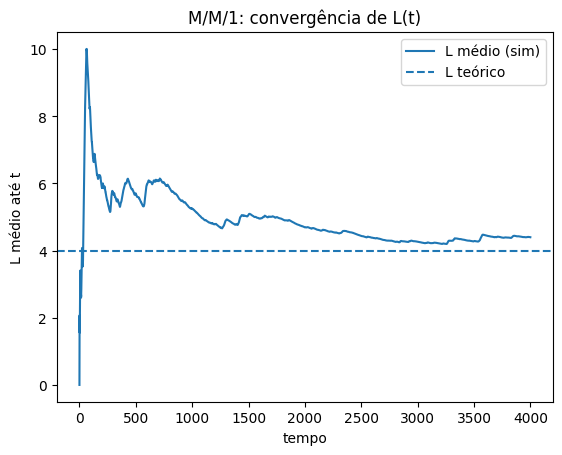

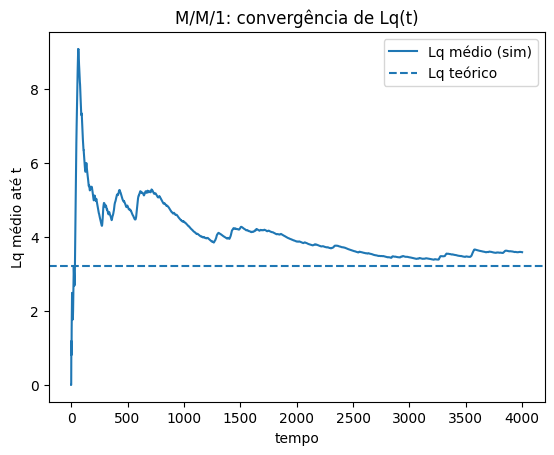


=== M/M/1/10 ===
Teórico: {'rho': 0.8, 'L': np.float64(2.9663142664841535), 'Lq': np.float64(2.1851085525480785), 'W': np.float64(0.7594195007966572), 'Wq': np.float64(0.5594195007966574), 'P_block': np.float64(0.023492857579905616), 'lam_eff': np.float64(3.9060285696803776)}
Simulado: L=3.028, Lq=2.239, W=0.772, Wq=0.570, P_block=0.027, lam_eff=3.892


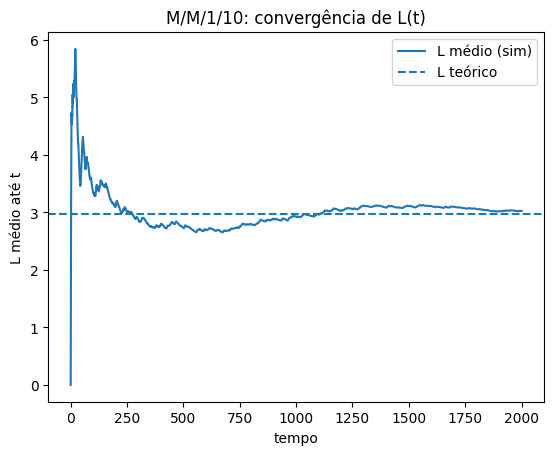


=== M/M/∞ ===
Teórico: {'rho': 0.0, 'L': 0.8, 'Lq': 0.0, 'W': 0.2, 'Wq': 0.0}
Simulado: L=0.789, W=0.197


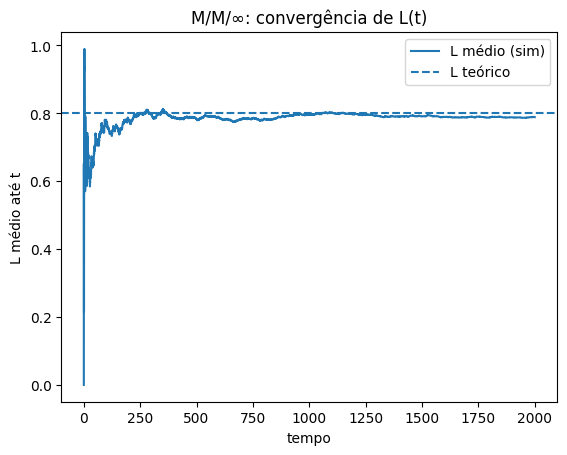


=== M/M/3 ===
Teórico: {'rho': 0.8333333333333334, 'L': 6.011235955056181, 'Lq': 3.511235955056181, 'W': 0.30056179775280906, 'Wq': 0.17556179775280906, 'P_wait': 0.7022471910112359, 'P0': 0.0449438202247191}
Simulado: L=6.302, Lq=3.798, W=0.314, Wq=0.189


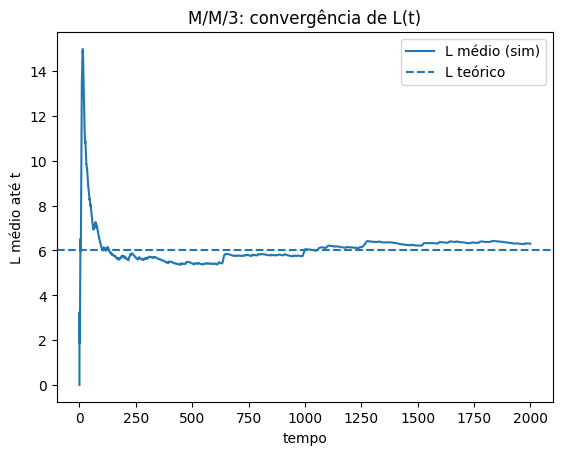

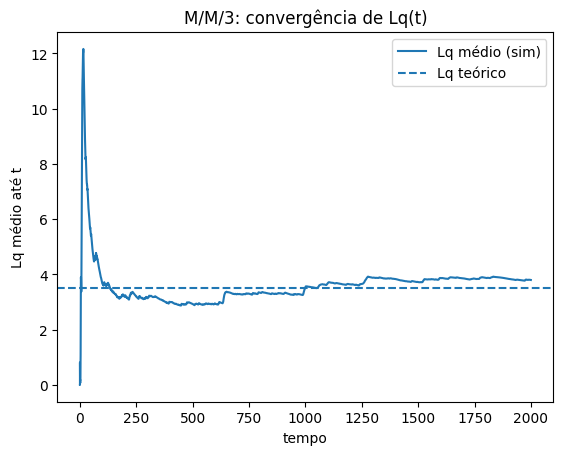


=== M/M/1 com prioridades (2 classes) ===
Teórico (agregado): {'rho': 0.6, 'L': 1.4999999999999998, 'Lq': 0.8999999999999999, 'W': 0.5, 'Wq': 0.3}
Simulado agregado: L=1.461, Lq=0.861
Médias por classe:
  Classe 1 (alta):  W=0.394, Wq=0.197
  Classe 2 (baixa): W=0.675, Wq=0.468


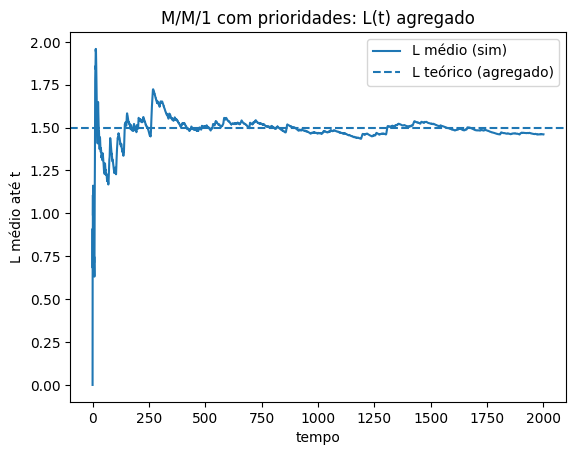

In [13]:
# --- Experimento 1: M/M/1 ---
lam, mu = 4.0, 5.0  # rho = 0.8
T_max = 4000.0

print("=== M/M/1 ===")
theo = mm1_metrics(lam, mu)
print("Teórico:", theo)

res = simulate_mm1(lam, mu, T_max, seed=123)
print("Simulado (T=%.0f): L=%.3f, Lq=%.3f, W=%.3f, Wq=%.3f" %
      (T_max, res["L"], res["Lq"], res["W"], res["Wq"]))

plt.figure()
plt.plot(res["times"], res["avg_L"], label="L médio (sim)")
plt.axhline(theo["L"], linestyle="--", label="L teórico")
plt.xlabel("tempo")
plt.ylabel("L médio até t")
plt.title("M/M/1: convergência de L(t)")
plt.legend()
plt.show()

plt.figure()
plt.plot(res["times"], res["avg_Lq"], label="Lq médio (sim)")
plt.axhline(theo["Lq"], linestyle="--", label="Lq teórico")
plt.xlabel("tempo")
plt.ylabel("Lq médio até t")
plt.title("M/M/1: convergência de Lq(t)")
plt.legend()
plt.show()


# --- Experimento 2: M/M/1/K ---
lam, mu, K = 4.0, 5.0, 10
T_max = 2000.0
print("\n=== M/M/1/%d ===" % K)
theoK = mm1K_metrics(lam, mu, K)
print("Teórico:", theoK)

resK = simulate_mm1K(lam, mu, K, T_max, seed=321)
print("Simulado: L=%.3f, Lq=%.3f, W=%.3f, Wq=%.3f, P_block=%.3f, lam_eff=%.3f" %
      (resK["L"], resK["Lq"], resK["W"], resK["Wq"], resK["P_block"], resK["lam_eff"]))

plt.figure()
plt.plot(resK["times"], resK["avg_L"], label="L médio (sim)")
plt.axhline(theoK["L"], linestyle="--", label="L teórico")
plt.xlabel("tempo")
plt.ylabel("L médio até t")
plt.title("M/M/1/%d: convergência de L(t)" % K)
plt.legend()
plt.show()


# --- Experimento 3: M/M/∞ ---
lam, mu = 4.0, 5.0
T_max = 2000.0
print("\n=== M/M/∞ ===")
theo_inf = mminf_metrics(lam, mu)
print("Teórico:", theo_inf)

res_inf = simulate_mminf(lam, mu, T_max, seed=456)
print("Simulado: L=%.3f, W=%.3f" % (res_inf["L"], res_inf["W"]))

plt.figure()
plt.plot(res_inf["times"], res_inf["avg_L"], label="L médio (sim)")
plt.axhline(theo_inf["L"], linestyle="--", label="L teórico")
plt.xlabel("tempo")
plt.ylabel("L médio até t")
plt.title("M/M/∞: convergência de L(t)")
plt.legend()
plt.show()


# --- Experimento 4: M/M/c ---
lam, mu, c = 20.0, 8.0, 3   # rho = lam/(c*mu)
T_max = 2000.0
print("\n=== M/M/%d ===" % c)
theo_c = mmc_metrics(lam, mu, c)
print("Teórico:", theo_c)

res_c = simulate_mmc(lam, mu, c, T_max, seed=789)
print("Simulado: L=%.3f, Lq=%.3f, W=%.3f, Wq=%.3f" %
      (res_c["L"], res_c["Lq"], res_c["W"], res_c["Wq"]))

plt.figure()
plt.plot(res_c["times"], res_c["avg_L"], label="L médio (sim)")
plt.axhline(theo_c["L"], linestyle="--", label="L teórico")
plt.xlabel("tempo")
plt.ylabel("L médio até t")
plt.title("M/M/%d: convergência de L(t)" % c)
plt.legend()
plt.show()

plt.figure()
plt.plot(res_c["times"], res_c["avg_Lq"], label="Lq médio (sim)")
plt.axhline(theo_c["Lq"], linestyle="--", label="Lq teórico")
plt.xlabel("tempo")
plt.ylabel("Lq médio até t")
plt.title("M/M/%d: convergência de Lq(t)" % c)
plt.legend()
plt.show()


# --- Experimento 5: M/M/1 com prioridades ---
lam1, lam2, mu = 2.0, 1.0, 5.0   # λ_total=3, ρ=0.6
T_max = 2000.0
print("\n=== M/M/1 com prioridades (2 classes) ===")
theo_pr = mm1_priority_overall_metrics(lam1, lam2, mu)
print("Teórico (agregado):", theo_pr)

res_p = simulate_mm1_priority(lam1, lam2, mu, T_max, seed=135)
print("Simulado agregado: L=%.3f, Lq=%.3f" % (res_p["L"], res_p["Lq"]))
print("Médias por classe:")
print("  Classe 1 (alta):  W=%.3f, Wq=%.3f" % (res_p["W1"],  res_p["Wq1"]))
print("  Classe 2 (baixa): W=%.3f, Wq=%.3f" % (res_p["W2"],  res_p["Wq2"]))

plt.figure()
plt.plot(res_p["times"], res_p["avg_L"], label="L médio (sim)")
plt.axhline(theo_pr["L"], linestyle="--", label="L teórico (agregado)")
plt.xlabel("tempo")
plt.ylabel("L médio até t")
plt.title("M/M/1 com prioridades: L(t) agregado")
plt.legend()
plt.show()


## Exercícios

1. **Aquecimento (M/M/1)**  
   - Fixe μ = 5 e varie λ ∈ {1, 2, 3, 4}.  
   - Para cada λ, estime W, W_q via simulação e compare com as fórmulas teóricas.  
   - Plote a média amostral de W_n (média dos primeiros n clientes atendidos) em função de n
     e discuta como a convergência fica mais lenta à medida que ρ → 1.

2. **Efeito da capacidade (M/M/1/K)**  
   - Fixe λ = 4, μ = 5 e varie K ∈ {3, 5, 10, 20}.  
   - Para cada K, estime a probabilidade de bloqueio P_block e compare com o valor teórico.  
   - Plote P_block em função de K e comente o trade-off entre “perda de clientes” e tamanho do sistema.

3. **M/M/∞ como modelo de “sem fila”**  
   - Fixe λ = 4, μ = 5. Estime L pela simulação M/M/∞ e compare com L = λ/μ.  
   - Em instantes de tempo fixos (por exemplo t = 100, 200, 500), colete N(t) em várias replicações
     e faça um histograma comparando com a pmf Poisson(λ/μ).

4. **Efeito do número de servidores (M/M/c)**  
   - Fixe λ = 20, μ = 8 e considere c ∈ {2, 3, 4}.  
   - Para cada c, estime W_q e compare com a fórmula de Erlang-C.  
   - Plote W_q em função de c e discuta o fenômeno de “diminuição rápida” com poucos servidores extras.

5. **Equidade em filas com prioridades (M/M/1 prio)**  
   - Considere λ_1 (alta prioridade), λ_2 (baixa prioridade), μ fixo. Por exemplo:
     - Caso A: λ_1 = 1, λ_2 = 2, μ = 5  
     - Caso B: λ_1 = 2, λ_2 = 1, μ = 5  
   - Para cada caso, estime W_1, W_2, Wq_1, Wq_2.  
   - Compare W_1 vs W_2 e discuta por que a classe de baixa prioridade “paga a conta”.

6. **Transiente vs regime permanente**  
   - Para um M/M/1 com ρ alto (por exemplo λ = 4.5, μ = 5), plote L(t) (média acumulada) a partir de t = 0.  
   - Repita o experimento iniciando o sistema “quente” (começando com vários clientes já na fila).  
   - Discuta a importância de descartar um período de aquecimento (warm-up) em simulações.
